In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

Model loaded successfully!


2025-09-10 12:26:10.220 Python[53727:40379503] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


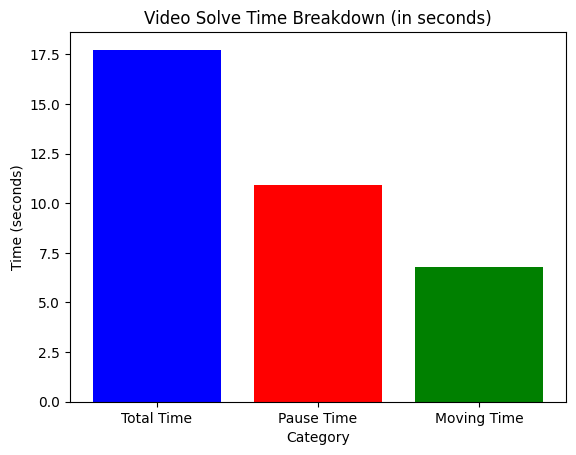

Total Solve Time: 17.73 seconds
Pause Time: 10.93 seconds
Moving Time: 6.80 seconds


In [ ]:
model_path = 'mobilenetv2_cube_model.keras'  
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully!")

#preprocess frame
def preprocess_frame(frame):
  img = cv2.resize(frame, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
  img = np.array(img) / 255.0
  img = tf.clip_by_value(img, 0.0, 1.0)
  return np.expand_dims(img, axis=0)

#video input
def real_time_detection(video_path):
  if not video_path or not os.path.exists(video_path):
    print("Error: Invalid or empty video path. Please provide a valid path.")
    return

  cap = cv2.VideoCapture(video_path)  
  
  if not cap.isOpened():
    print("Error: Could not open video.")
    return

  frame_count = 0
  paused_time = 0
  moving_time = 0
  fps = cap.get(cv2.CAP_PROP_FPS) if cap.get(cv2.CAP_PROP_FPS) > 0 else 30  
  frame_time = 1 / fps  
  threshold = 0.5  

  while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
      break

    #preprocess
    processed_frame = preprocess_frame(frame)
    prediction = model.predict(processed_frame, verbose=0)[0][0]  
    state = 'Paused' if prediction < threshold else 'Moving'
    #formatting
    color = (0, 0, 255) if state == 'Paused' else (0, 255, 0)
    cv2.putText(frame, f"{state} ({prediction:.2f})", (30, 200), cv2.FONT_HERSHEY_SIMPLEX, 5, color, 6, cv2.LINE_AA)
    cv2.rectangle(frame, (0, 0), (frame.shape[1], frame.shape[0]), color, 10)

    #display
    cv2.imshow('Real-Time Cube Detection', frame)

    #time tracking)
    if state == 'Paused':
      paused_time += frame_time
    else:
      moving_time += frame_time

    frame_count += 1
    if cv2.waitKey(1) & 0xFF == ord('q'):  
      break

  cap.release()
  cv2.destroyAllWindows()

  total_time = frame_count / fps

  #graph
  times = [total_time, paused_time, moving_time]
  labels = ['Total Time', 'Pause Time', 'Moving Time']
  plt.bar(labels, times, color=['blue', 'red', 'green'])
  plt.title('Video Solve Time Breakdown (in seconds)')
  plt.ylabel('Time (seconds)')
  plt.xlabel('Category')
  plt.show()

  print(f"Total Solve Time: {total_time:.2f} seconds")
  print(f"Pause Time: {paused_time:.2f} seconds")
  print(f"Moving Time: {moving_time:.2f} seconds")

video_path = input("Enter the path to your video file (e.g., '../CubeDataSet/videos/test.mp4'): ")
real_time_detection(video_path)
